# Module 4: Pytorch Implementation of Autoencoder

## Introduction

In this notebook we will build upon the PyTorch foundations from Module 3 and implement a different kind of Neural Network Architecture: an Autoencoder.

Autoencoders main goal is to learn a simplified or encoded representation of a dataset. First we divide the network into two halves, an encoder and a decoder. The encoder starts with the input and reduces it to a simpler latent representation and the decoder takes that representation and reproduces the original input.

In the following notebook we will look at two different autoencoders. The first is a simple autoencoder that will be trained on 3 different MNIST digits. We will then visualize the 2D latent representation.

The next is a larger network that we will train on the entire MNIST dataset and effectively reconstruct input images from the output!

## Simple Autoencoder with 0, 1, 2 MNIST Digits

For our first Autoencoder network, we will recreate the example shown in Module 4 using the digits 0, 1, and 2 from the MNIST dataset.

First we will train our autoencoder using RMSE with the inputs and labels being the same. Once our autoencoder is trained, we will visualized the 2D latent space encoding.




### Dataset Preparation and Module Import

Here we will load in the MNIST dataset we used in the Module 3 assignment. It is built into Pytorch so it's super easy to use!

Additionally, we will prune the dataset to only contain the digits 0, 1, and 2.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import time, copy
# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
# These transforms will be performed on every datapoint - in this example we want to transform every
# datapoint to a Tensor datatype, and perform normalization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
mnist_train = torchvision.datasets.MNIST('', train=True, transform =transform, download=True)
# Here we will only keep the digits 0, 1, and 2
train_indices = [idx for idx, target in enumerate(mnist_train.targets) if target in [0, 1, 2]]
print(len(train_indices))
mnist_train = Subset(mnist_train, train_indices)

# We will split out train dataset into train and validation!
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [int(np.floor(len(mnist_train)*0.75)), int(np.ceil(len(mnist_train)*0.25))])

# Keep only the digits 0, 1, and 2 for the test as well
mnist_test = torchvision.datasets.MNIST('', train=False, transform = transform, download=True)
test_indices = [idx for idx, target in enumerate(mnist_test.targets) if target in [0, 1, 2]]
mnist_test = Subset(mnist_test, test_indices)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.74MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 180kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.57MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.10MB/s]


18623


In [3]:
# We will create DataLoaders just like before with a batch size of 100
batch_size = 100
dataloaders = {'train': DataLoader(mnist_train, batch_size=batch_size),
               'val': DataLoader(mnist_val, batch_size=batch_size),
               'test': DataLoader(mnist_test, batch_size=batch_size)}

dataset_sizes = {'train': len(mnist_train),
                 'val': len(mnist_val),
                 'test': len(mnist_test)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 13967, 'val': 4656, 'test': 3147}


### Model Hyperparameters and Definition

This network is very simple to the networks built in Module 3, with Linear layers and ReLU activation. However, notice that we have separated into two distinct sections: and encoder and decoder. By writing the code this way, it allows us to easily encode a specific datapoint after our model is trained.

In [5]:
class SimpleAutoEncoder(nn.Module):
    def __init__(self, input_size):
        super(SimpleAutoEncoder, self).__init__()
        # Split the Encoder and Decoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_size)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

    def encode(self, x):
        return self.encoder(x)



In [6]:
# hyperparameters

input_size = 784 # flattening our dataset 28*28 = 784
learning_rate = 0.001
num_epochs = 5

In [7]:
model = SimpleAutoEncoder(input_size).to(device)
print(model)

SimpleAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=784, bias=True)
  )
)


### Training the Model

This training function is very similar to the ones written in previous sections. The key thing to notice is that an autoencoder is very similar to a regression so we don't have specific class labels/accuracy, only loss.

In [8]:
# From https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_autoencoder(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # keep the best weights stored separately
    best_loss = np.inf
    best_epoch = 0

    # Each epoch has a training, validation, and test phase
    phases = ['train', 'val', 'test']

    # Keep track of how loss evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data - for the autoencoder we don't care about the
            # labels, we are training the input against itself!
            for inputs, _ in dataloaders[phase]:
                # Important! We need to flatten every datapoint to be
                # compatible with our model!
                print(inputs.shape)
                inputs = inputs.view(inputs.shape[0],-1)
                inputs = inputs.to(device)
                # our targets are the same as our inputs!
                targets = inputs.to(device)
                print(inputs.shape)
                # print(targets.shape)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # print(outputs.shape)
                    loss = criterion(outputs, targets)

                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)

            print(f'{phase:5} Loss: {epoch_loss:.4f}')

            # deep copy the model if it's the best loss
            if phase == 'val' and epoch_loss < best_loss:
              best_epoch = epoch
              best_loss = epoch_loss
              best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Loss: {best_loss:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, training_curves



In [9]:
# loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

model, training_curves = train_autoencoder(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/5
----------
torch.Size([100, 1, 28, 28])
torch.Size([100, 784])
torch.Size([100, 1, 28, 28])
torch.Size([100, 784])
torch.Size([100, 1, 28, 28])
torch.Size([100, 784])
torch.Size([100, 1, 28, 28])
torch.Size([100, 784])
torch.Size([100, 1, 28, 28])
torch.Size([100, 784])
torch.Size([100, 1, 28, 28])
torch.Size([100, 784])
torch.Size([100, 1, 28, 28])
torch.Size([100, 784])
torch.Size([100, 1, 28, 28])
torch.Size([100, 784])
torch.Size([100, 1, 28, 28])
torch.Size([100, 784])
torch.Size([100, 1, 28, 28])
torch.Size([100, 784])
torch.Size([100, 1, 28, 28])
torch.Size([100, 784])
torch.Size([100, 1, 28, 28])
torch.Size([100, 784])
torch.Size([100, 1, 28, 28])
torch.Size([100, 784])
torch.Size([100, 1, 28, 28])
torch.Size([100, 784])
torch.Size([100, 1, 28, 28])
torch.Size([100, 784])
torch.Size([100, 1, 28, 28])
torch.Size([100, 784])
torch.Size([100, 1, 28, 28])
torch.Size([100, 784])
torch.Size([100, 1, 28, 28])
torch.Size([100, 784])
torch.Size([100, 1, 28, 28])
torch.Size([1

### Visualizing the Latent Space Encoding

Now that our autoencoder is trained, let's visualize the 2D latent space encoding for our different digits!

In [10]:
import matplotlib.pyplot as plt

x = []
label = []
# random subset of test and grab x and y
# plot in matplotlib
for inputs, labels in dataloaders["test"]:
    inputs = inputs.view(inputs.shape[0],-1)
    inputs = inputs.to(device)
    for i, input in enumerate(inputs):
        encoding = model.encode(input)
        x.append(encoding.cpu().detach().numpy())
        label.append(labels[i])

def plot_dataset(x,y):
    print(len(x))
    print(len(y))
    x_np = np.array(x)
    x_np.reshape(len(x), 2)
    colors = []
    for label in y:
        if label == 0:
            colors.append("red")
        elif label == 1:
            colors.append("blue")
        else:
            colors.append("green")
    plt.scatter(x_np[...,0], x_np[...,1], color=colors)


3147
3147


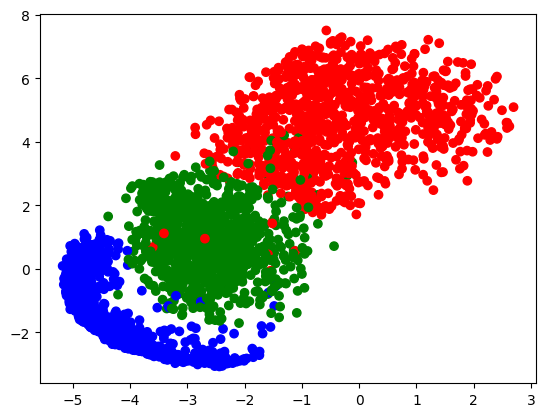

In [ ]:
plot_dataset(x,label)

We can see here that our encoding does a great job of separating the different digit classes. There are 3 distinct clusters here for each of the digits 0, 1, and 2.

## Autoencoder on Entire MNIST Dataset

Now that we have visualized what an autoencoder can do in latent space, we will build a deeper network and expand to the entire MNIST dataset.

The training process will be exactly the same as before, our network will just contain more layers and a higher dimensional latent space to more accurately reproduce our input.

### Dataset Preparation

In [11]:
# These transforms will be performed on every datapoint - in this example we want to transform every
# datapoint to a Tensor datatype, and perform normalization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
mnist_train = torchvision.datasets.MNIST('', train=True, transform =transform, download=True)

# We will split out train dataset into train and validation!
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [int(np.floor(len(mnist_train)*0.75)), int(np.ceil(len(mnist_train)*0.25))])

mnist_test = torchvision.datasets.MNIST('', train=False, transform = transform, download=True)

In [12]:
# We will create DataLoaders just like before with a batch size of 100
batch_size = 100
dataloaders = {'train': DataLoader(mnist_train, batch_size=batch_size),
               'val': DataLoader(mnist_val, batch_size=batch_size),
               'test': DataLoader(mnist_test, shuffle=True, batch_size=batch_size)}

dataset_sizes = {'train': len(mnist_train),
                 'val': len(mnist_val),
                 'test': len(mnist_test)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 45000, 'val': 15000, 'test': 10000}


### Model Hyperparameters and Definition

Here we are using a latent space with dimension 32. That will allow for a lot more information to be encoded which should lead to more accurate decoding.

In [13]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size):
        super(AutoEncoder, self).__init__()
        ## Split the Encoder and Decoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256,32)
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 256),
            nn.ReLU(),
            nn.Linear(256, input_size)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

    def encode(self, x):
        return self.encoder(x)



In [14]:
# hyperparameters

input_size = 784 # flattening our dataset 28*28 = 784
learning_rate = 0.001
num_epochs = 10

In [15]:
model = AutoEncoder(input_size).to(device)
print(model)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
  )
)


### Training the Model

We will actually use the exact same training function as above since we are still training an AutoEncoder! We have copied it below for your convience.

In [16]:
# From https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_autoencoder(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # keep the best weights stored separately
    best_loss = np.inf
    best_epoch = 0

    # Each epoch has a training, validation, and test phase
    phases = ['train', 'val', 'test']

    # Keep track of how loss evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data - for the autoencoder we don't care about the
            # labels, we are training the input against itself!
            for inputs, _ in dataloaders[phase]:
                # Important! We need to flatten every datapoint to be
                # compatible with our model!
                inputs = inputs.view(inputs.shape[0],-1)
                inputs = inputs.to(device)
                # our targets are the same as our inputs!
                targets = inputs.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)

            print(f'{phase:5} Loss: {epoch_loss:.4f}')

            # deep copy the model if it's the best loss
            if phase == 'val' and epoch_loss < best_loss:
              best_epoch = epoch
              best_loss = epoch_loss
              best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Loss: {best_loss:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, training_curves



In [17]:
# loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

model, training_curves = train_autoencoder(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 0.1246
val   Loss: 0.0726
test  Loss: 0.0712

Epoch 2/10
----------
train Loss: 0.0686
val   Loss: 0.0651
test  Loss: 0.0637

Epoch 3/10
----------
train Loss: 0.0636
val   Loss: 0.0616
test  Loss: 0.0603

Epoch 4/10
----------
train Loss: 0.0604
val   Loss: 0.0588
test  Loss: 0.0576

Epoch 5/10
----------
train Loss: 0.0576
val   Loss: 0.0564
test  Loss: 0.0553

Epoch 6/10
----------
train Loss: 0.0556
val   Loss: 0.0548
test  Loss: 0.0537

Epoch 7/10
----------
train Loss: 0.0540
val   Loss: 0.0531
test  Loss: 0.0521

Epoch 8/10
----------
train Loss: 0.0525
val   Loss: 0.0517
test  Loss: 0.0508

Epoch 9/10
----------
train Loss: 0.0512
val   Loss: 0.0506
test  Loss: 0.0497

Epoch 10/10
----------
train Loss: 0.0502
val   Loss: 0.0496
test  Loss: 0.0487

Training complete in 0m 43s
Best val Loss: 0.049648 at epoch 9


### Visualizing the Results

Now that our model is trained we want to visualize the results of our AutoEncoder!

We have provided a function below that will display the input and the autoencoding of a specified digit. Try running it for different digits and seeing which ones look closest to each other!

In [18]:
import matplotlib.pyplot as plt

# plot a digit ground truth and autoencoding
def plot_digit(digit, count = 1):
    fig = plt.figure()
    idx = 1
    for inputs, labels in dataloaders["test"]:
        # Flatten dataset so the dimensions line up with our model
        inputs = inputs.view(inputs.shape[0],-1)
        inputs = inputs.to(device)
        for i, input in enumerate(inputs):
            # We only want to display a certain digit
            if (labels[i] != digit):
                continue
            # run the autoencoder
            autoencoding = model.forward(input)
            # move back to the cpu()
            autoencoding = autoencoding.cpu().detach().numpy()
            # reshape to an image
            autoencoding = autoencoding.reshape((28,28))
            input = input.cpu().detach().numpy().reshape((28,28))
            # plot the ground truth
            ax = fig.add_subplot(2, count, idx)
            ax.imshow(input, cmap='gray')
            # plot the autoencoding
            ax = fig.add_subplot(2, count, idx+count)
            ax.imshow(autoencoding, cmap='gray')
            idx += 1
            if idx > count:
                break
        if idx > count:
            break

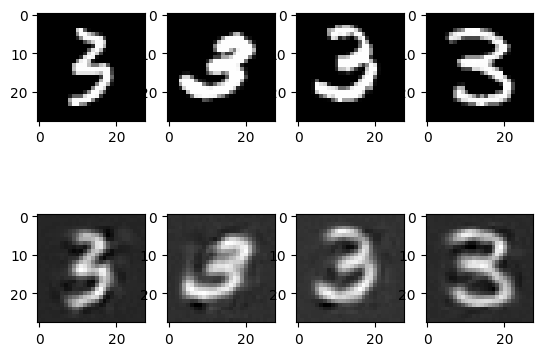

In [19]:
plot_digit(3, 4)

Looking at the output of our autoencoder above, we can see that a latent space of dimension 32 does a great job at storing enough information to make a good reconstruction!

## Looking Ahead

Up until this point we have been taking our MNIST images and flattening them into 1D arrays. Although we are still able to get some great results, we are losing out of a lot of spatial features that are available to us in 2D. In order to leverage these features, we will introduce a new layer to our neural networks, Convolutional Layers.